# Slope estimation: comparison of methods

## Author: M.Ravasi

This notebook compares different methods for the estimation of local slopes ($p=dt/dx$) from seismic data:

- Analytical: this is possible for our specific choice of data (i.e., hyperbolic events) as we can represent the data with a analytical time-space relationship and therefore we can also analytically compute the slopes;

- Structure tensor: this is a commonly used technique that estimates local slopes in any image from their local gradients;

- Multi-channel slope estimation: this is the technique proposed in our work and relies on the direct (or smoothed) division of the time derivative of pressure and particle velocity data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops

from scipy import signal, ndimage
from pylops.utils.wavelets import ricker

from mcslopes.plotting import plotting_style
from mcslopes.slopes import analytic_local_slope, multicomponent_slopes, multicomponent_slopes_inverse, structure_tensor

plotting_style()

Let's start by creating our dataset composed of hyperbolic events.

In [2]:
par = {
    "ox": 0,
    "dx": 5,
    "nx": 151,
    
    "ot": 0,
    "dt": 0.004, #[s]
    "nt": 501,
    
    "oy": 0,
    "dy": 0,
    "ny": 0,
    
    "f0": 20,
    "nfmax": 210,}

nt, nx = par["nt"], par["nx"]
dt, dx = par["dt"], par["dx"]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(np.arange(41) * dt, f0=par["f0"])[0]

# Define velocity hyperbolic events
v0=800
kv=200
t0 = np.linspace(0., 1.8, 12)
vrms = v0 + kv * t0

# Create data
amp = np.ones(len(t0))
_, data = pylops.utils.seismicevents.hyperbolic2d(x, t, t0, vrms, amp, wav)

# Define traveltime curve along which slopes will be compared
ievent = 6 # event to track

tevent = np.sqrt(t0[ievent] ** 2 + x ** 2 / vrms[ievent] ** 2)
itevent = np.round(tevent/dt).astype(np.int64)

## Analytical slopes

In [3]:
analytical_slope = analytic_local_slope(data, dt, x, v0, kv);

/home/ravasim/Documents/2022/Projects/MultiCompSlopesInterpolation/mcslopes/slopes.py:51: RuntimeWarning: invalid value encountered in true_divide
  slope[it, ix] = x[ix] / (tapp * (v_rms[it0])**2)


## Structure tensor

In [4]:
slope_st = (-1/1000) * structure_tensor(data.T, dt*1000, dx, smooth=10)[0]

## Ratio-of-derivatives slopes

In [5]:
slope_mc = multicomponent_slopes(data, dx, dt, thresh=1e-3, nmedian=11);

/home/ravasim/Documents/2022/Projects/MultiCompSlopesInterpolation/mcslopes/slopes.py:185: RuntimeWarning: divide by zero encountered in true_divide
  slope_mc = mask * (-data_dx / data_dt)
/home/ravasim/Documents/2022/Projects/MultiCompSlopesInterpolation/mcslopes/slopes.py:185: RuntimeWarning: invalid value encountered in true_divide
  slope_mc = mask * (-data_dx / data_dt)
/home/ravasim/Documents/2022/Projects/MultiCompSlopesInterpolation/mcslopes/slopes.py:185: RuntimeWarning: invalid value encountered in multiply
  slope_mc = mask * (-data_dx / data_dt)


## Multi component slopes (as inverse problem)

In [6]:
slope_mcinv = multicomponent_slopes_inverse(data, dx, dt, reg=8e1, iter_lim=200);

## Final comparison

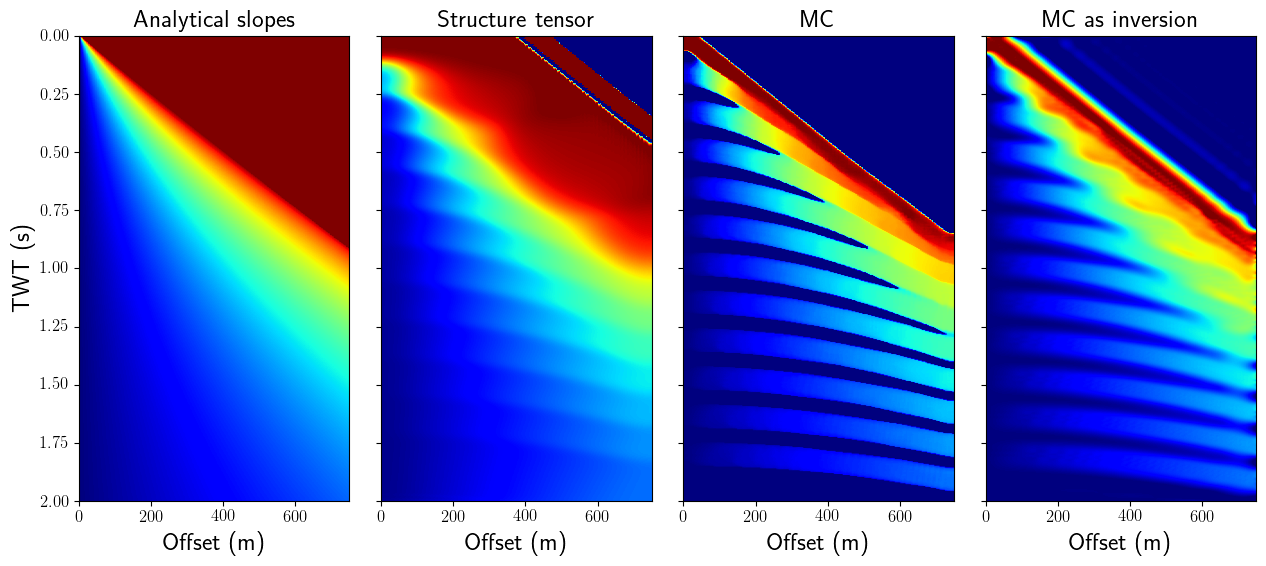

In [7]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(13, 6))
axs[0].imshow(analytical_slope, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Analytical slopes')
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].axis('tight')
axs[1].imshow(slope_st, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_title('Structure tensor')
axs[1].axis('tight')
axs[2].imshow(slope_mc, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_title('MC')
axs[2].axis('tight')
axs[3].imshow(slope_mcinv, cmap='jet', vmin=0, vmax=1.2e-3, extent=(x[0], x[-1], t[-1], t[0]))
axs[3].set_xlabel('Offset (m)')
axs[3].set_title('MC as inversion')
axs[3].axis('tight')
plt.tight_layout()

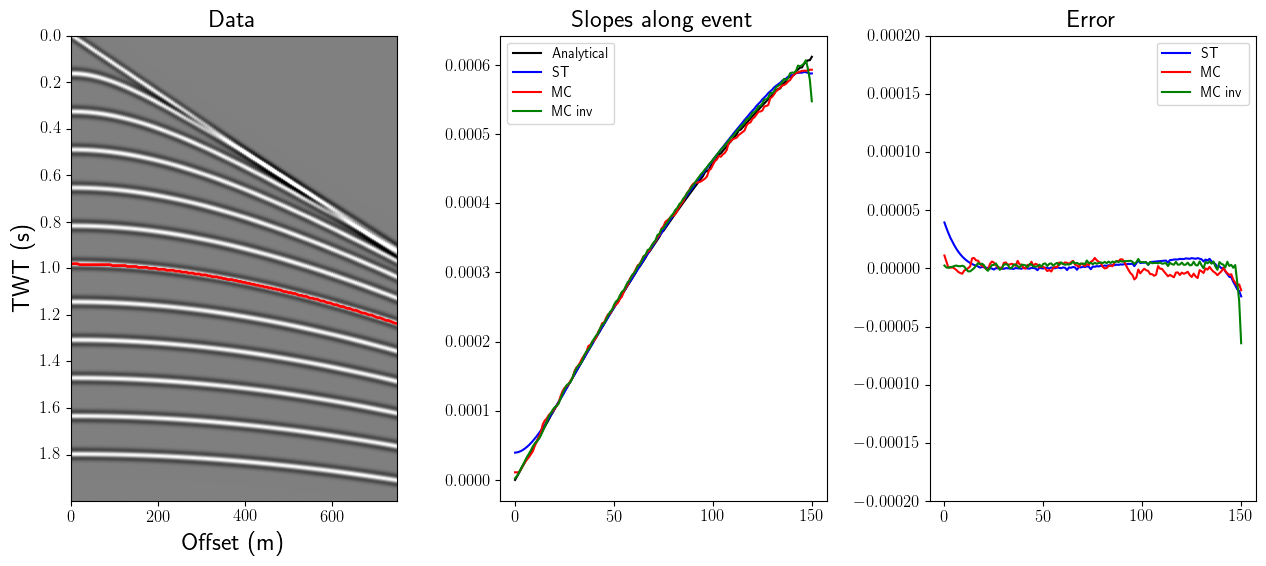

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(13, 6))
axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0], x[-1], t[-1], t[0]))
axs[0].plot(x, t[itevent], 'r', lw=2)
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (s)')
axs[0].set_title('Data')
axs[0].set_yticks(np.arange(0,2,.2))
axs[0].axis('tight')

axs[1].plot(analytical_slope[itevent, np.arange(nx)], 'k', label='Analytical')
axs[1].plot(slope_st[itevent, np.arange(nx)], 'b', label='ST')
axs[1].plot(slope_mc[itevent, np.arange(nx)], 'r', label='MC')
axs[1].plot(slope_mcinv[itevent, np.arange(nx)], 'g', label='MC inv')
axs[1].set_title('Slopes along event')
axs[1].legend()
axs[2].plot(slope_st[itevent, np.arange(nx)]-analytical_slope[itevent, np.arange(nx)], 'b', label='ST')
axs[2].plot(slope_mc[itevent, np.arange(nx)]-analytical_slope[itevent, np.arange(nx)], 'r', label='MC')
axs[2].plot(slope_mcinv[itevent, np.arange(nx)]-analytical_slope[itevent, np.arange(nx)], 'g',  label='MC inv')
axs[2].set_title('Error')
axs[2].set_ylim(-.0002, .0002)
axs[2].legend()
plt.tight_layout()